In [31]:
from keys import FTX_API_KEY, FTX_API_SECRET
import seaborn as sns
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utility_classes.correlation import Correlation, CSVManager
from utility_classes.historical_data_processor import FTXDataProcessor
import seaborn as sns 
import dateutil.parser as dp


acc = FTXDataProcessor(api_key=FTX_API_KEY, api_secret=FTX_API_SECRET)
corr = Correlation(
        spread_folder_path='/home/harry/trading_algo/crypto_trading_researches/strategy_backtests/historical_data/all_spreads',
        perp_folder_path='/home/harry/trading_algo/crypto_trading_researches/strategy_backtests/historical_data/all_perps',
        futures_folder_path='/home/harry/trading_algo/crypto_trading_researches/strategy_backtests/historical_data/expired_futures_data')

plt.rcParams['figure.figsize'] = [15, 15]


## Pearson's coefficient for spreads
### draw the daily spread heatmap for futures expiring in 2020/09/25 and 2020/12/25, with minimum value set to 0 


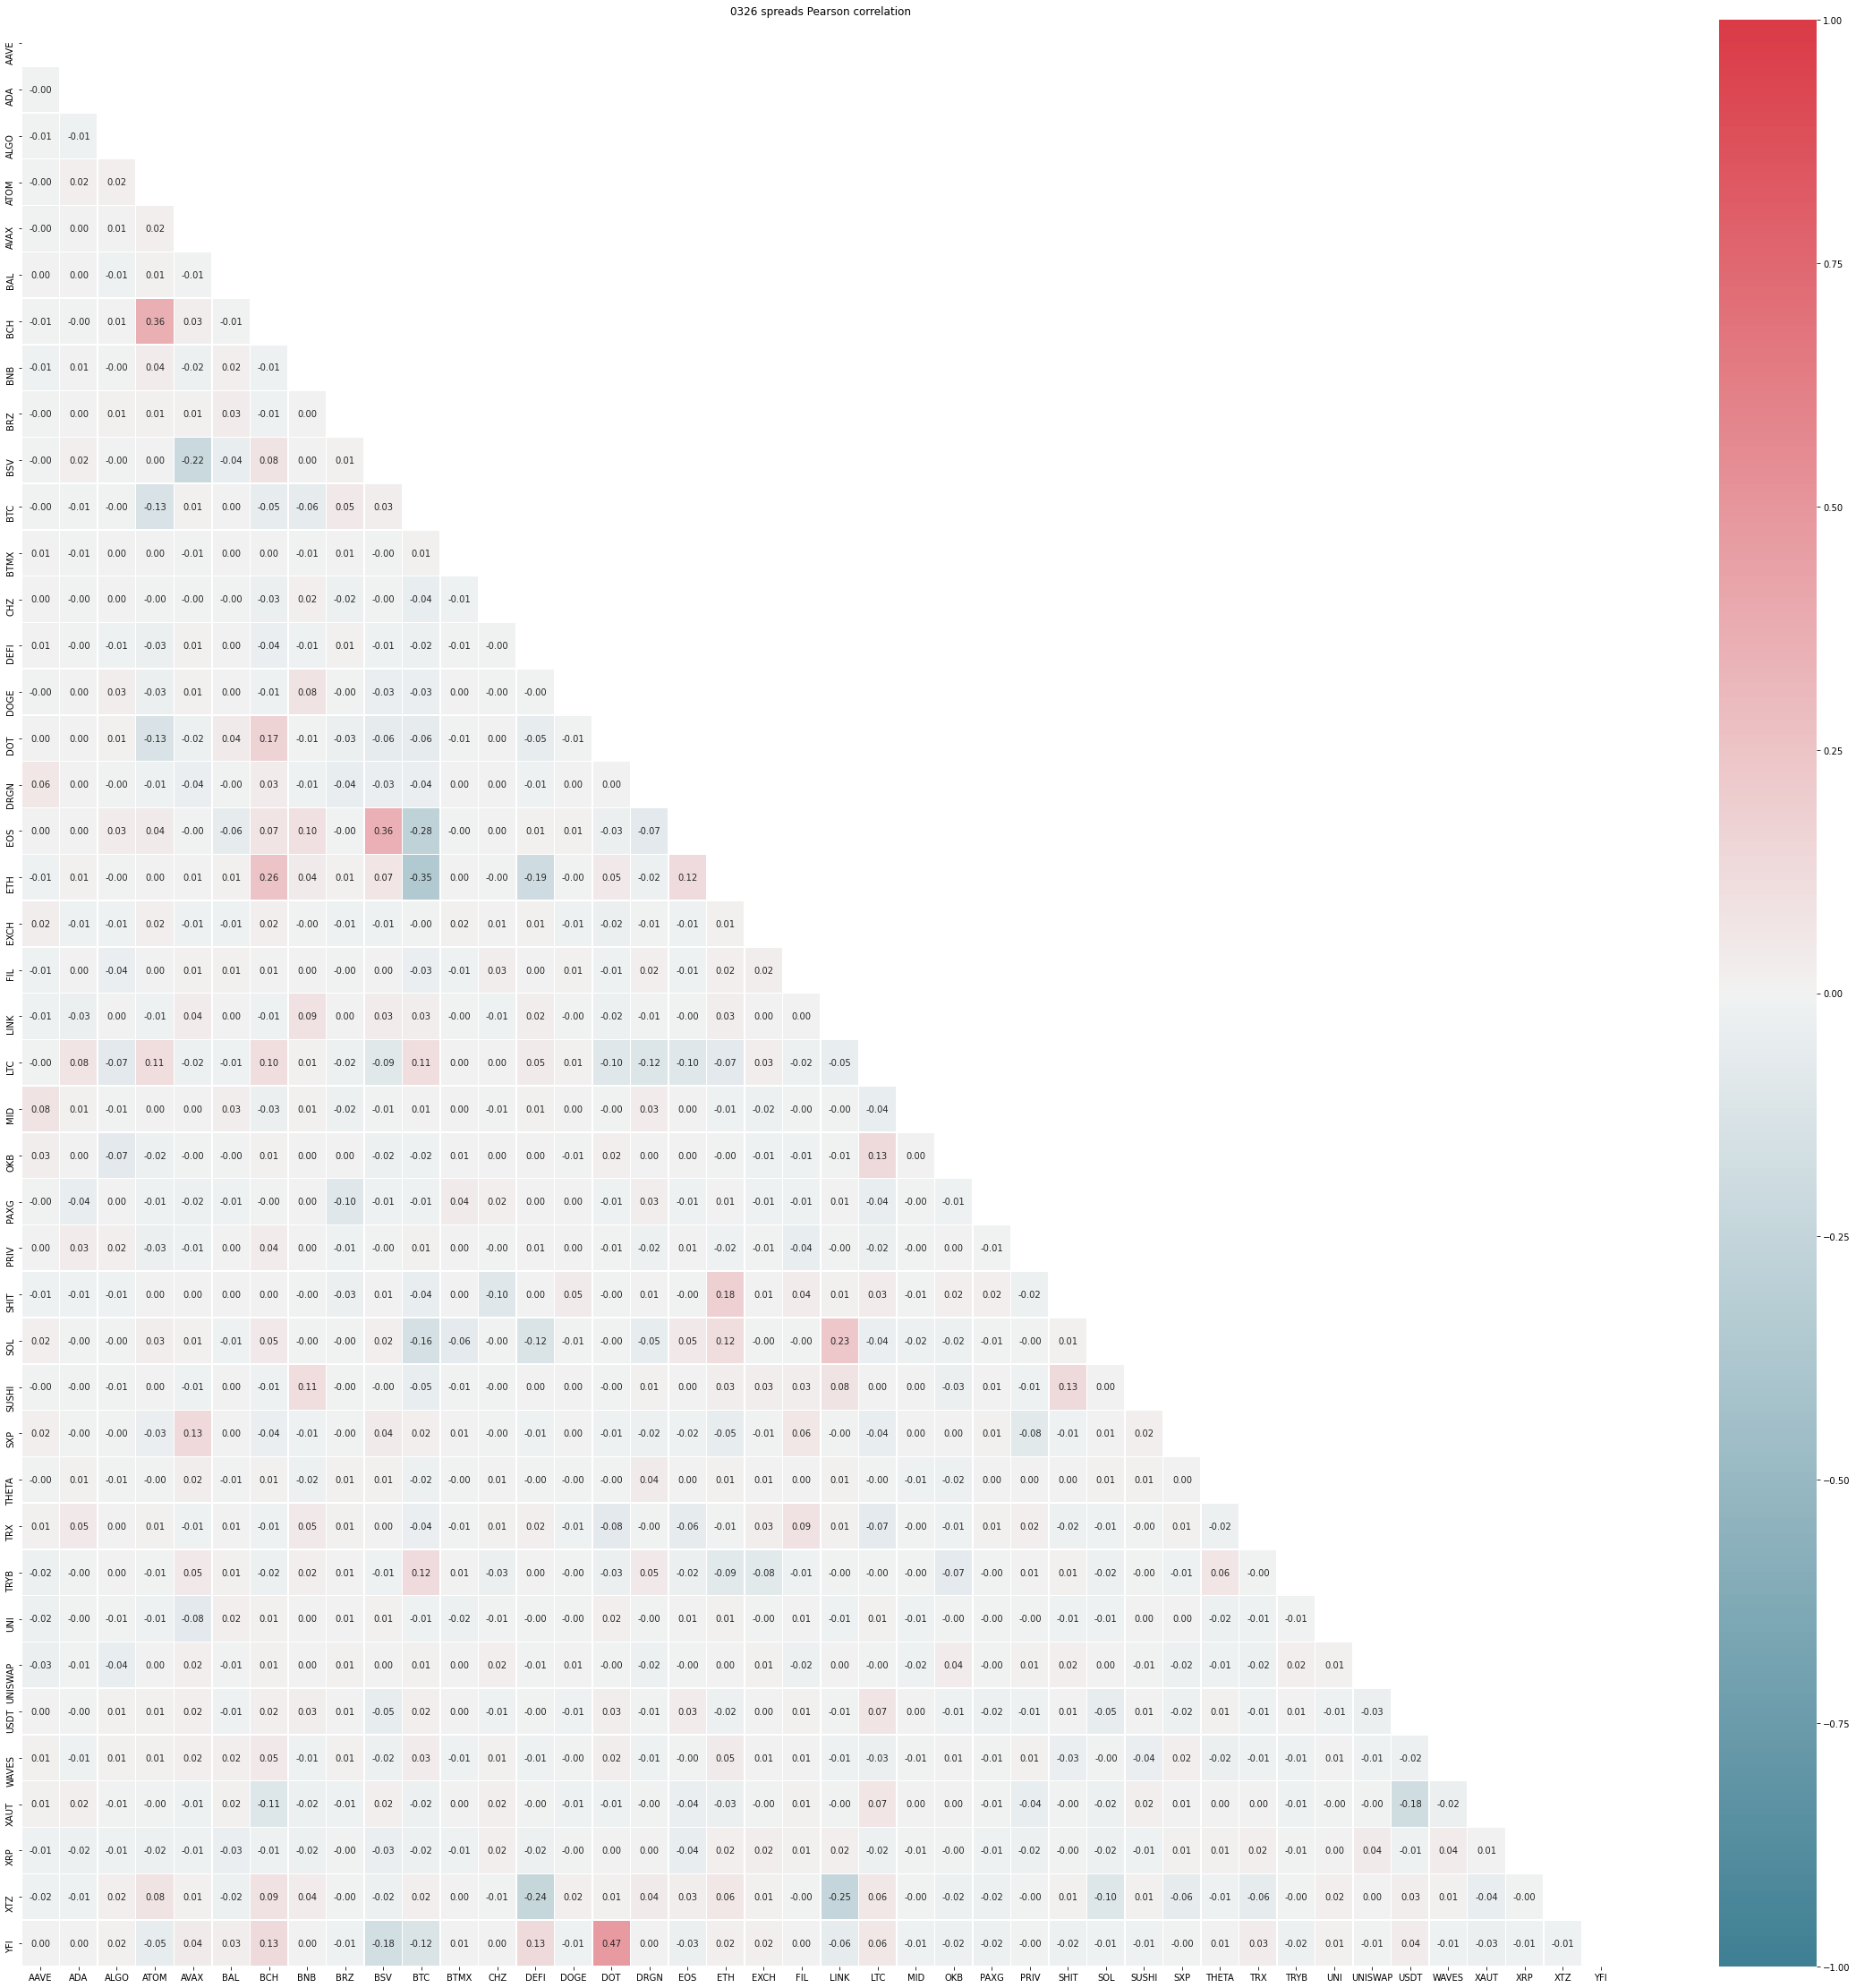

spreads from 2020-12-14T07:27:00+00:00 to 2021-03-26T03:00:00+00:00
['BCH', 'BNB', 'BTC', 'BTMX', 'DEFI', 'DOT', 'EOS', 'ETH', 'FIL', 'LTC', 'SOL', 'SUSHI', 'TRYB', 'USDT', 'WAVES', 'XRP', 'XTZ'] have missing values


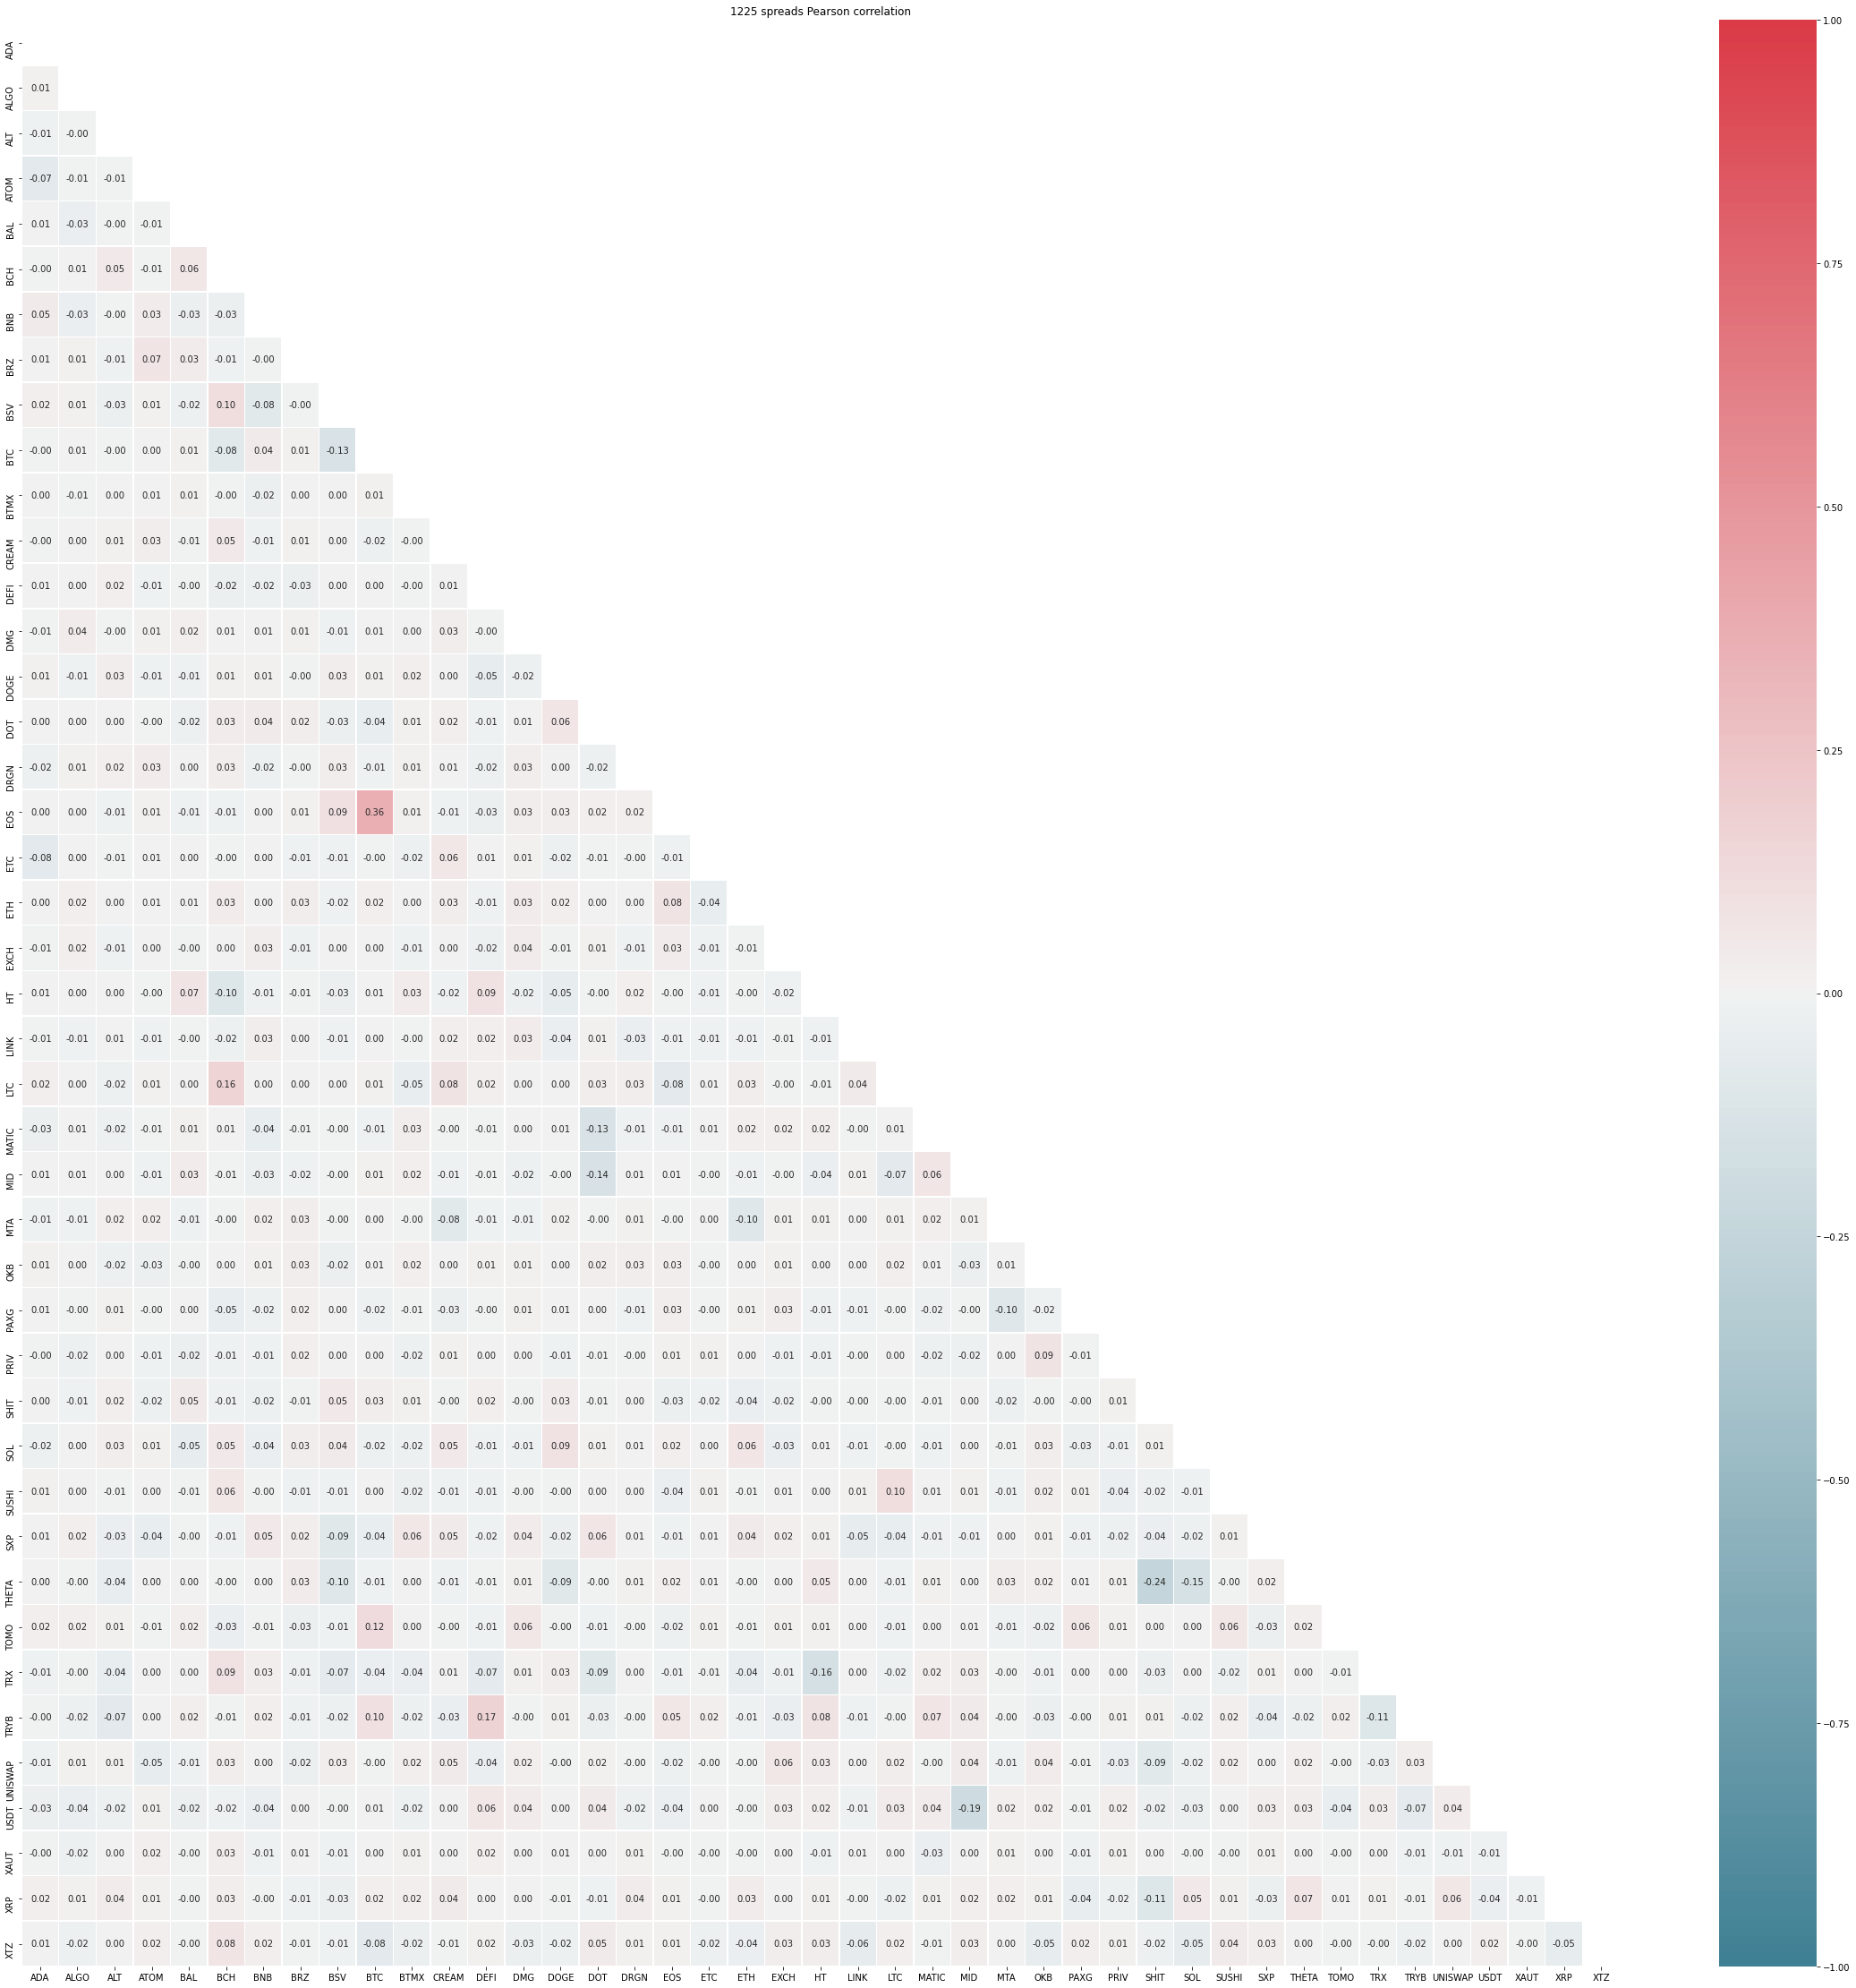

spreads from 2020-09-11T18:40:00+00:00 to 2020-12-25T03:00:00+00:00
['BTC', 'MTA'] have missing values


In [4]:
corr.spreads_correlation_heatmap(futures_date='0326', coint=False, triangular=True, timeframe='H', annot=True)
corr.spreads_correlation_heatmap(futures_date='1225', coint=False, triangular=True, timeframe='H', annot=True)

### however, correlation is not a good trading indicator. For example, if your pairs trading strategy is based on the spread between the prices of the two stocks, it is possible that the prices of the two stocks keep on increasing without ever mean-reverting.
### more reading on correlation vs cointegration https://www.r-bloggers.com/2017/11/cointegration-correlation-and-log-returns/

## Cointegration test among spreads. Here, looking for scores less than 0.05 to reject the null hypothesis that there is no cointegration
###  Cointegration is a statistical property of two or more time-series variables which indicates if a linear combination of the variables is stationary.
### Spread = log(token a) – nlog(token b); 

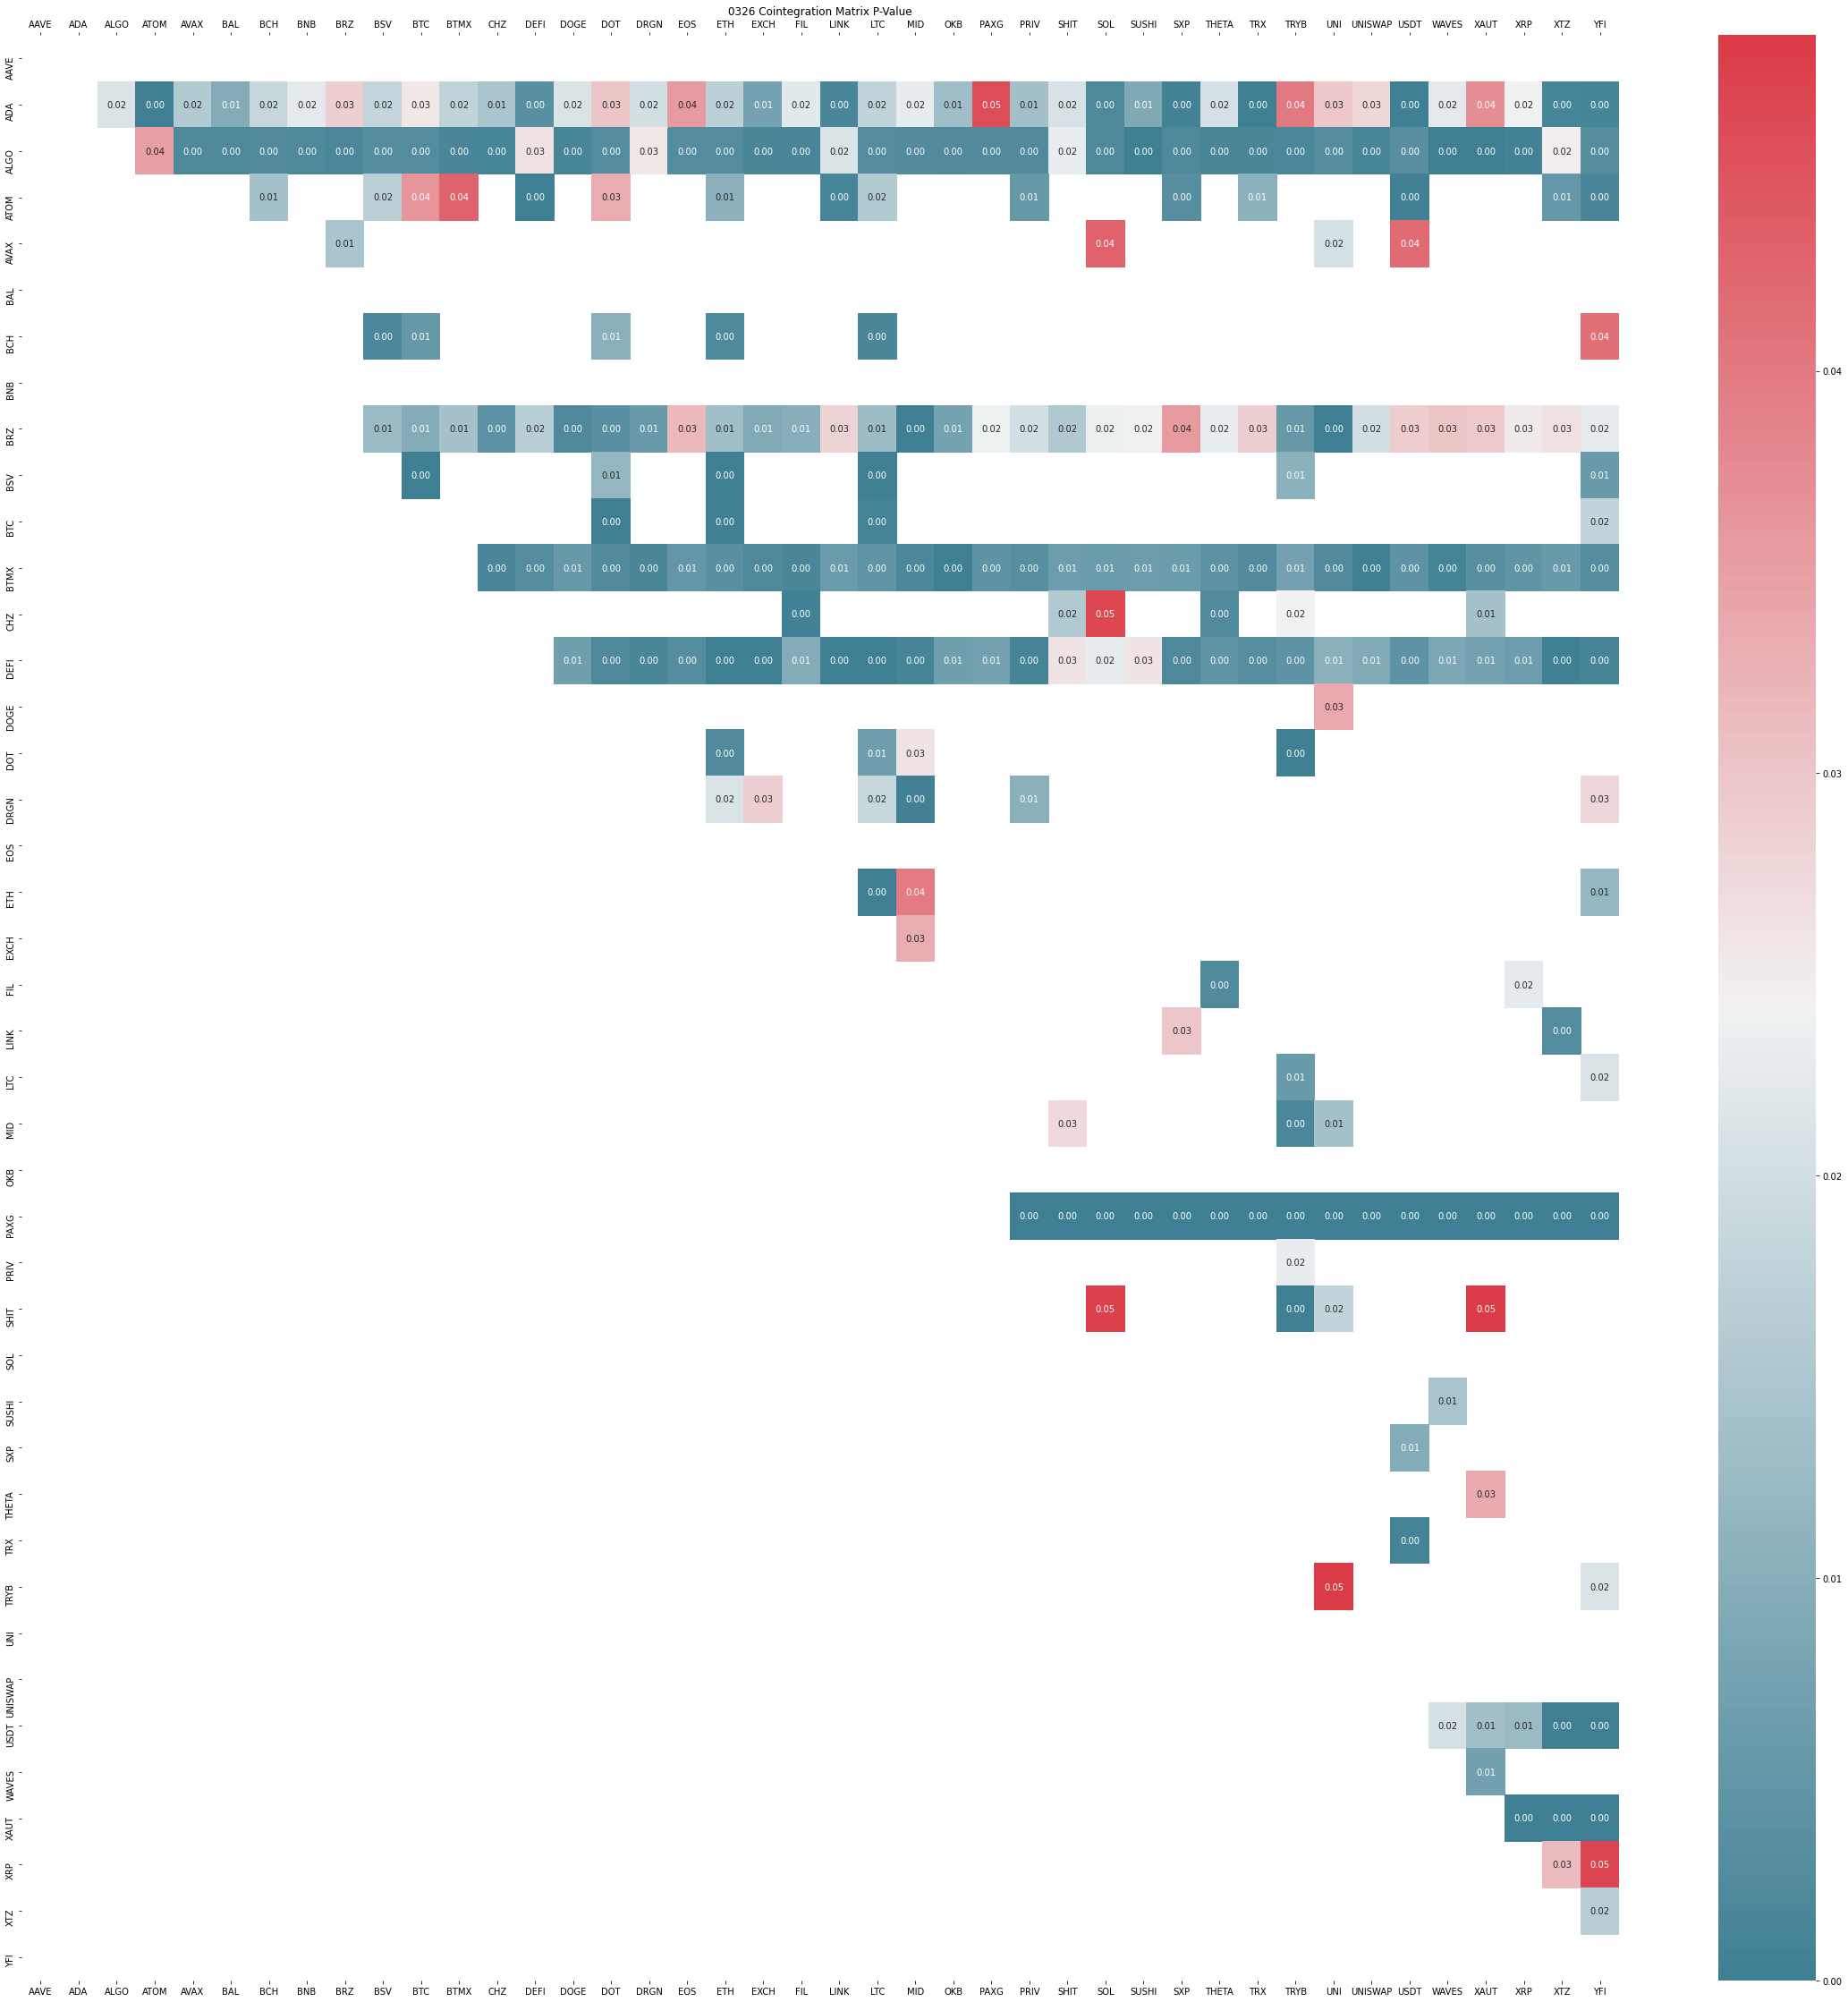

spreads from 2020-12-14T07:27:00+00:00 to 2021-03-26T03:00:00+00:00
['BCH', 'BNB', 'BTC', 'BTMX', 'DEFI', 'DOT', 'EOS', 'ETH', 'FIL', 'LTC', 'SOL', 'SUSHI', 'TRYB', 'USDT', 'WAVES', 'XRP', 'XTZ'] have missing values


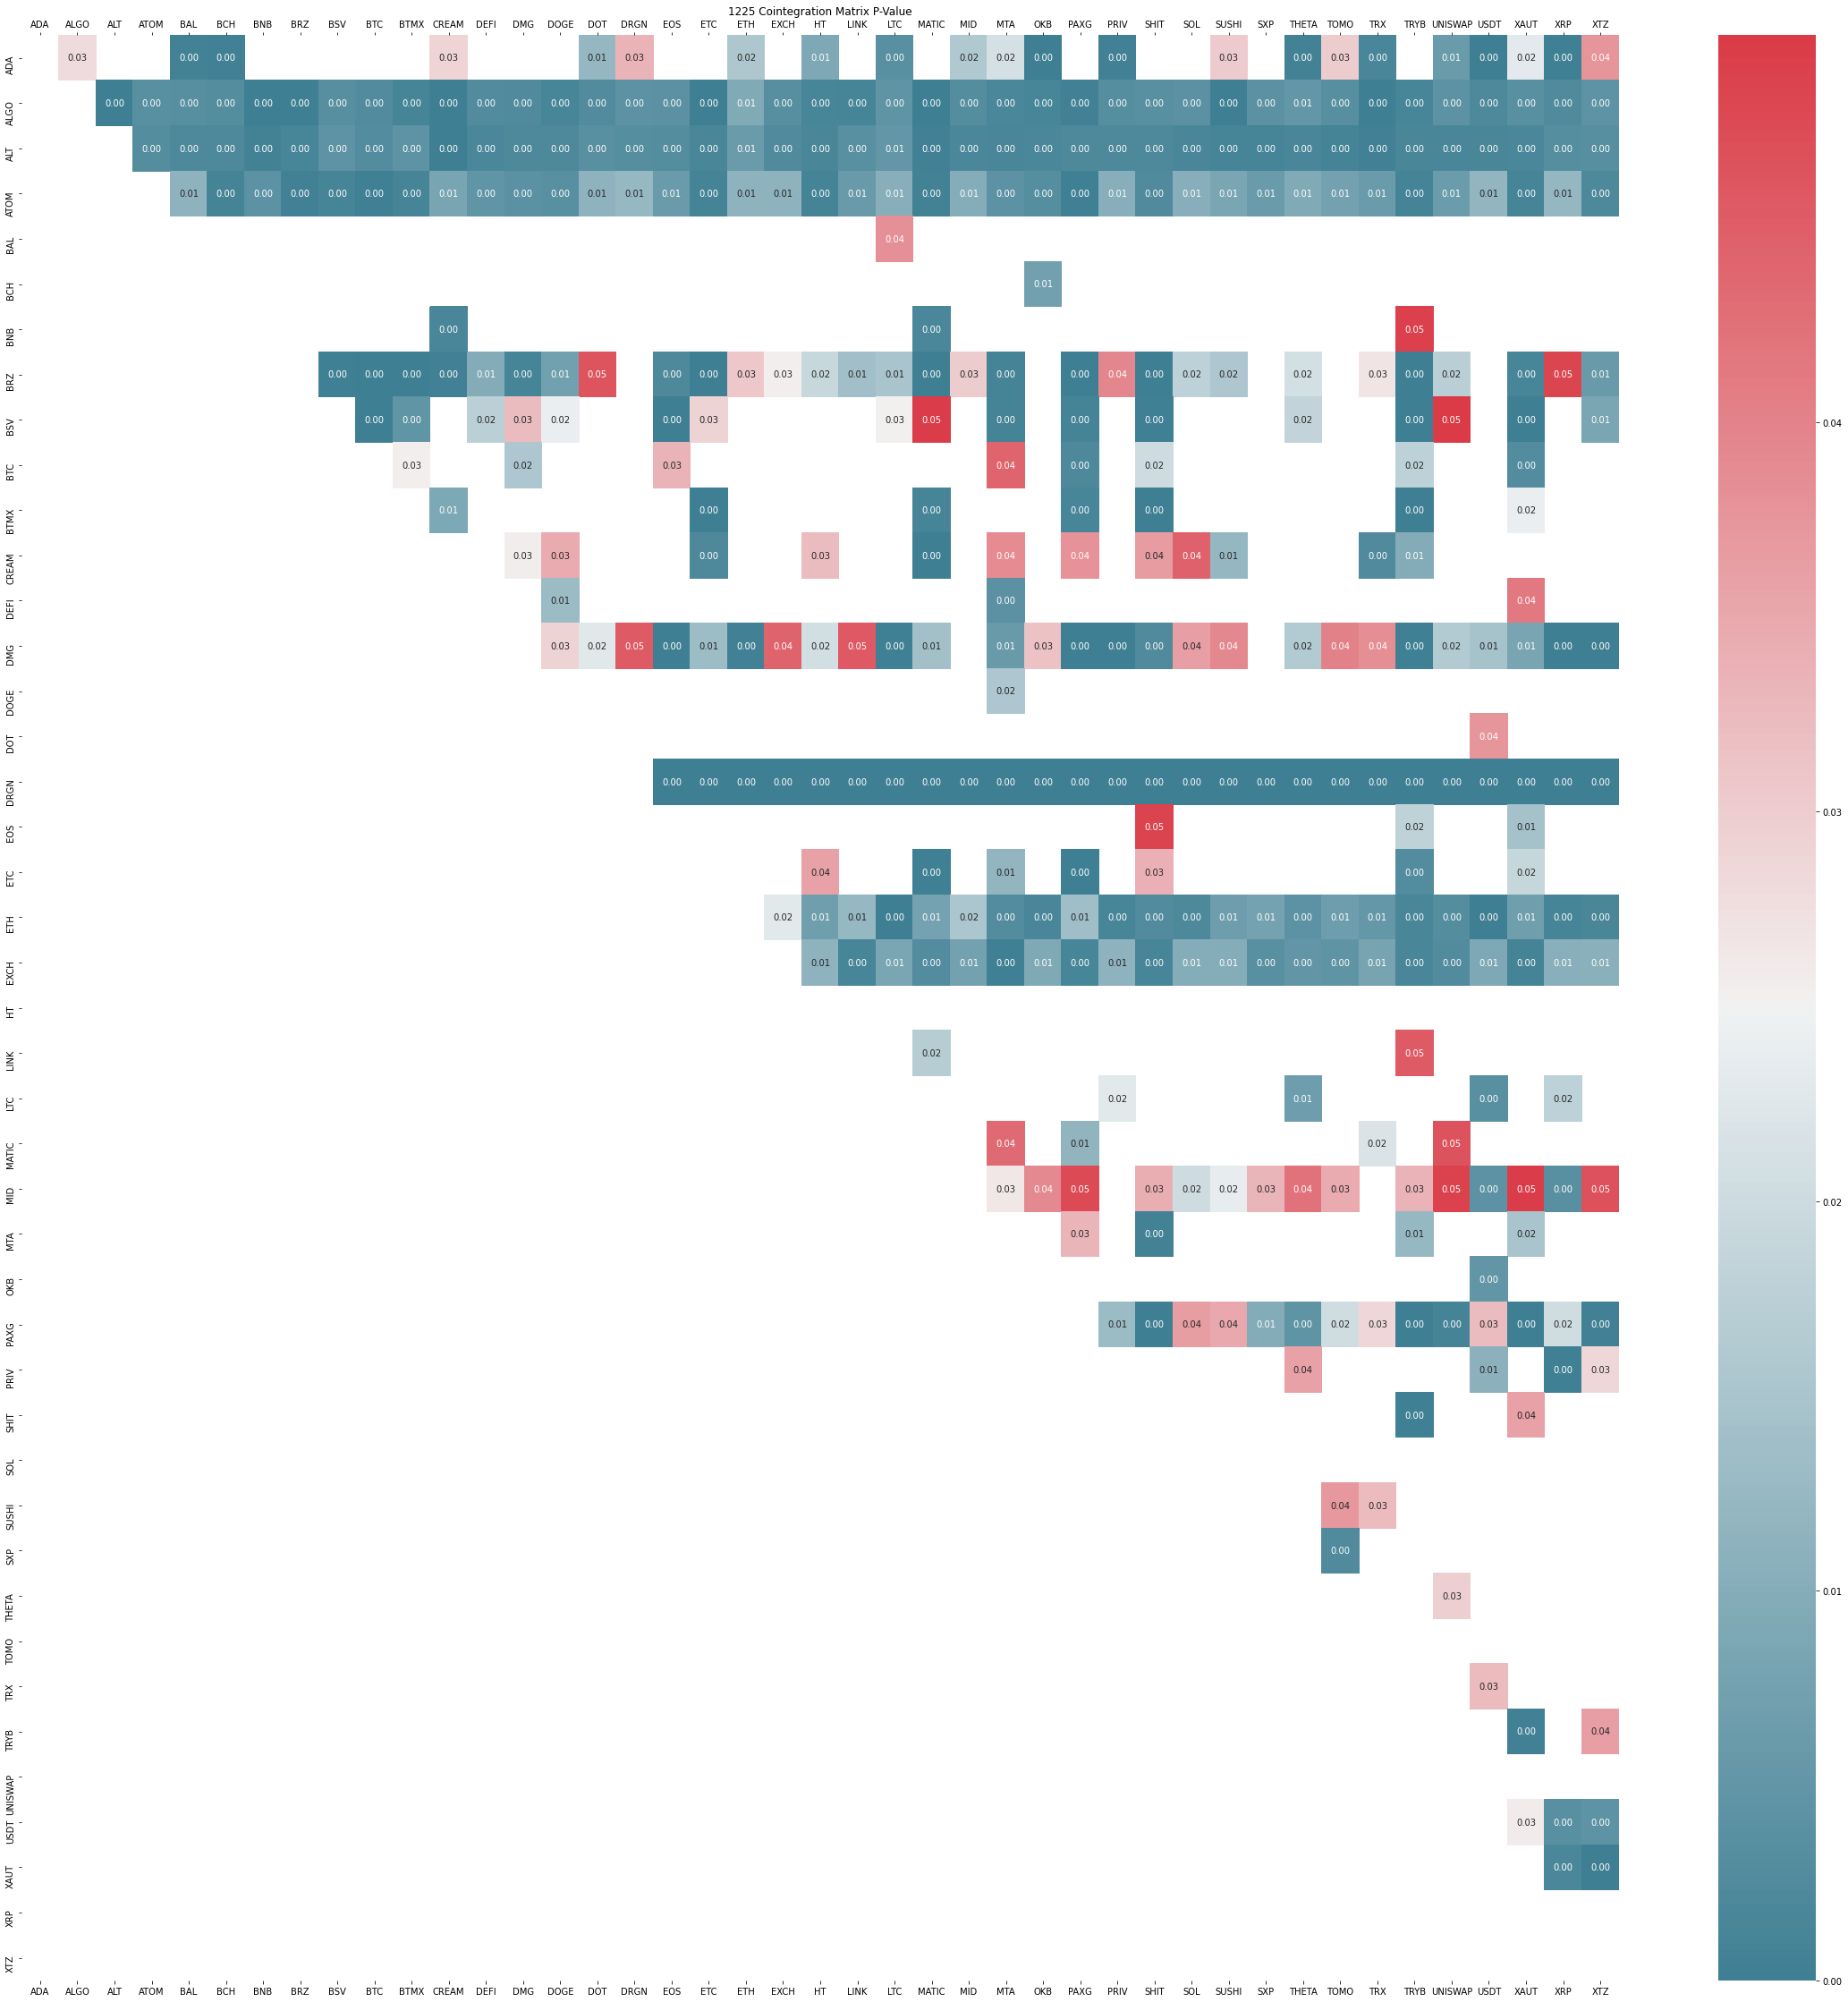

spreads from 2020-09-11T18:40:00+00:00 to 2020-12-25T03:00:00+00:00
['BTC', 'MTA'] have missing values


In [2]:
corr.spreads_correlation_heatmap(futures_date='0326', coint=True, timeframe='H', showing_only_below_threshold=True, annot=True)
corr.spreads_correlation_heatmap(futures_date='1225', coint=True, timeframe='H', showing_only_below_threshold=True, annot=True)


##  perp-future spread cointegration test among different assets (NaN are masked)
### comparing to the above heatmap, where 'spreads of spreads' is being tested, here the subject is only perp-future spread

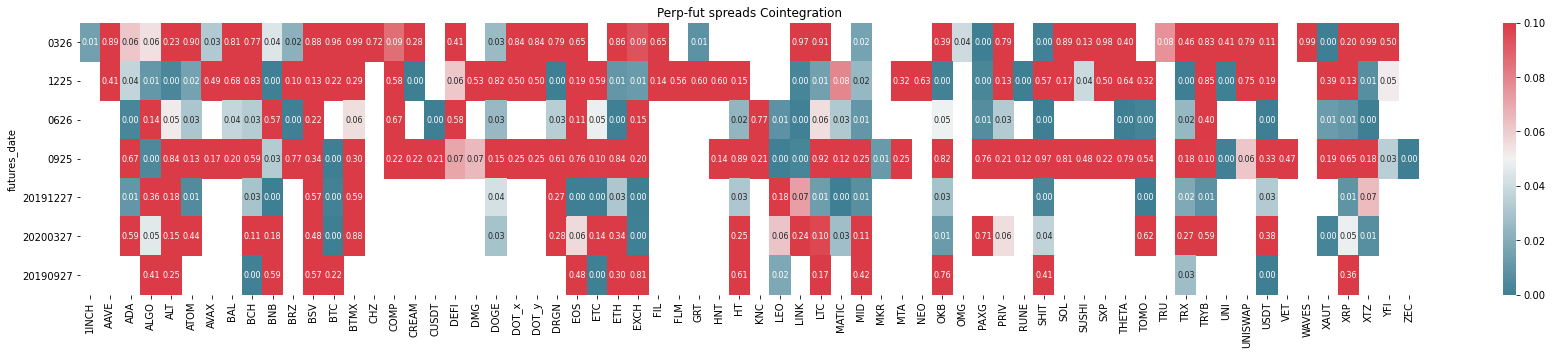

In [2]:
corr.pair_coint(True, '4H')


### here I will select tokens that display consistent cointegration to further test cointegration by calculating the hedge ratio 

### Get a visual sanity check to see the cointegrated pairs' historical spreads 

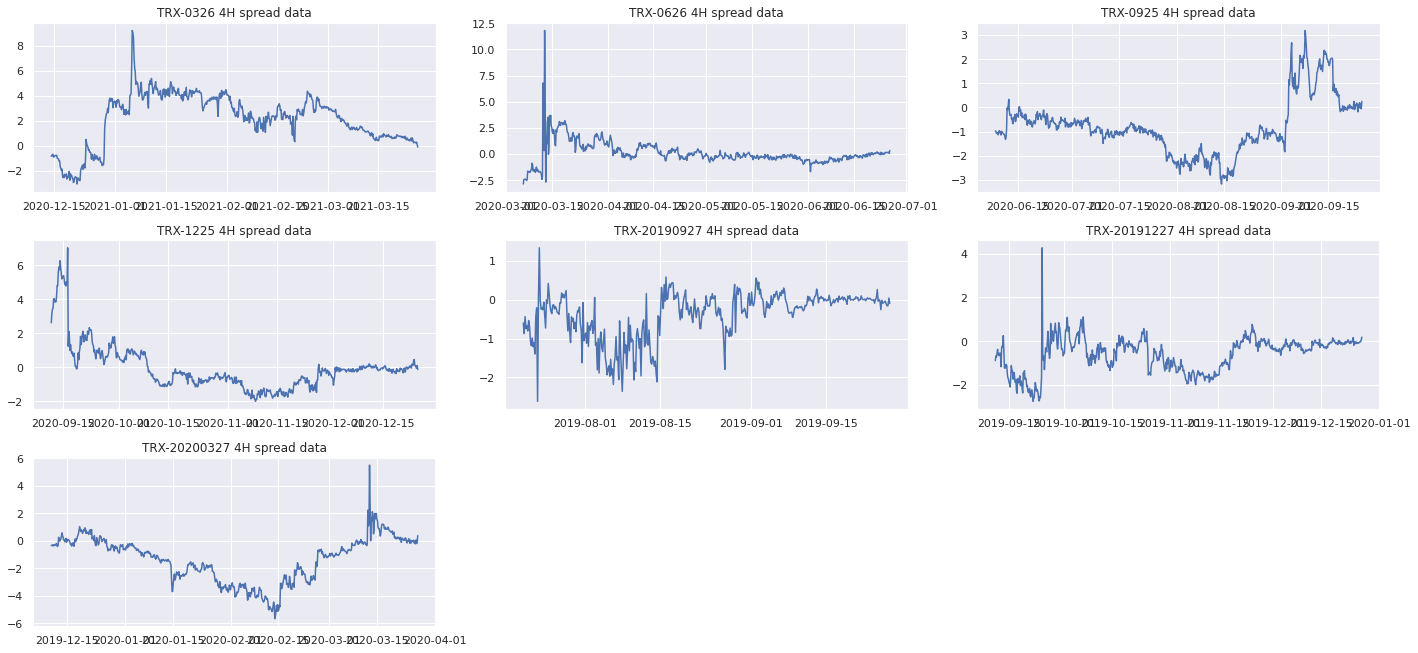

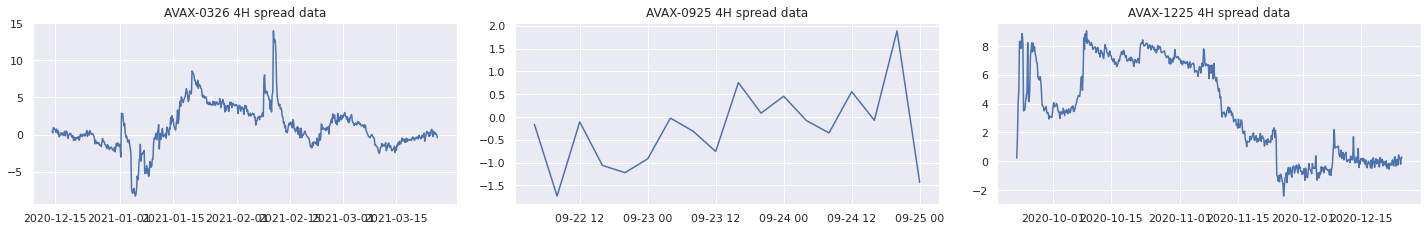

In [23]:
# corr.plot_historical_spread('DOGE', '4H')
# corr.plot_historical_spread('PAXG', '4H')
# corr.plot_historical_spread('BNB', '4H')
# corr.plot_historical_spread('ADA', '4H')
# corr.plot_historical_spread('SHIT', '4H')

corr.plot_historical_spread('TRX', '4H')
corr.plot_historical_spread('AVAX', '4H')


### some of the cointegrated pairs above don't fit the perfect definition of cointegration, in other words, their spreads' variance do seem to vary from time to time. My guess is because I used statsmodels' 'coint' function to calculate the cointegration, and because the underlying test for 'coint' function only tests whether there exists a unit root, data can have varying variance even without the presence of unit root. Therefore, to get more conclusive results, I may need to conduct more tests. i.e. Philip-Ouliaris test, Johansen test

## So far, only a few tokens exibit cointegrated movements in recent past (2021/03/31)

## now we can select the most cointegrated spreads, and explore their (1)historical spread price range, (2)volatility distribution (3)and funding rate volatility 

#### first, lets get the data visualization for the funding rate. This function uses datatime.now(), so it should give you the most up to date funding rate
#### user can choose lookback period in hours (time are denoted in utc time)


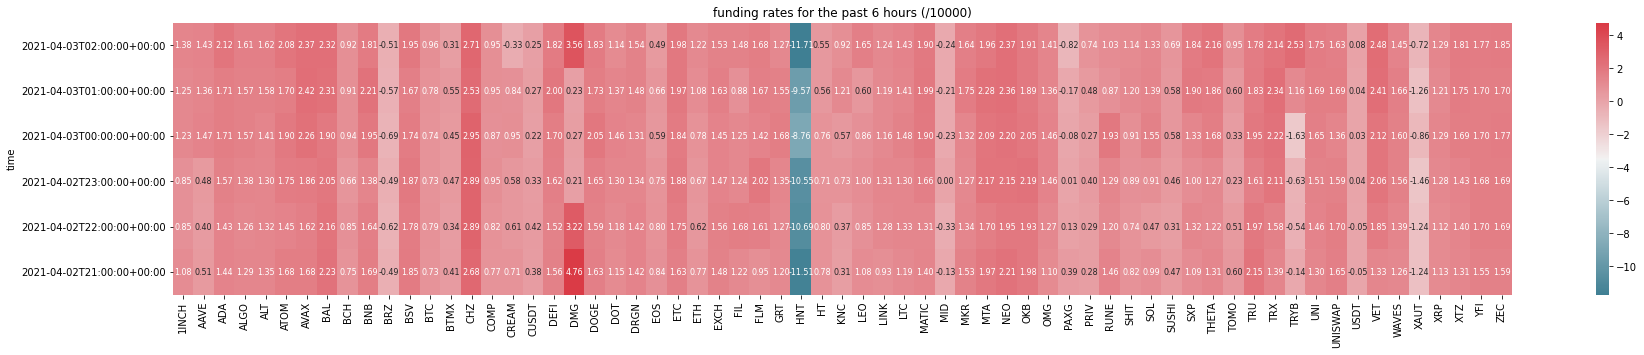

In [3]:
acc.get_latest_funding_for_perps_with_fut(6)

#### then, take a look at the historical funding rate volatility

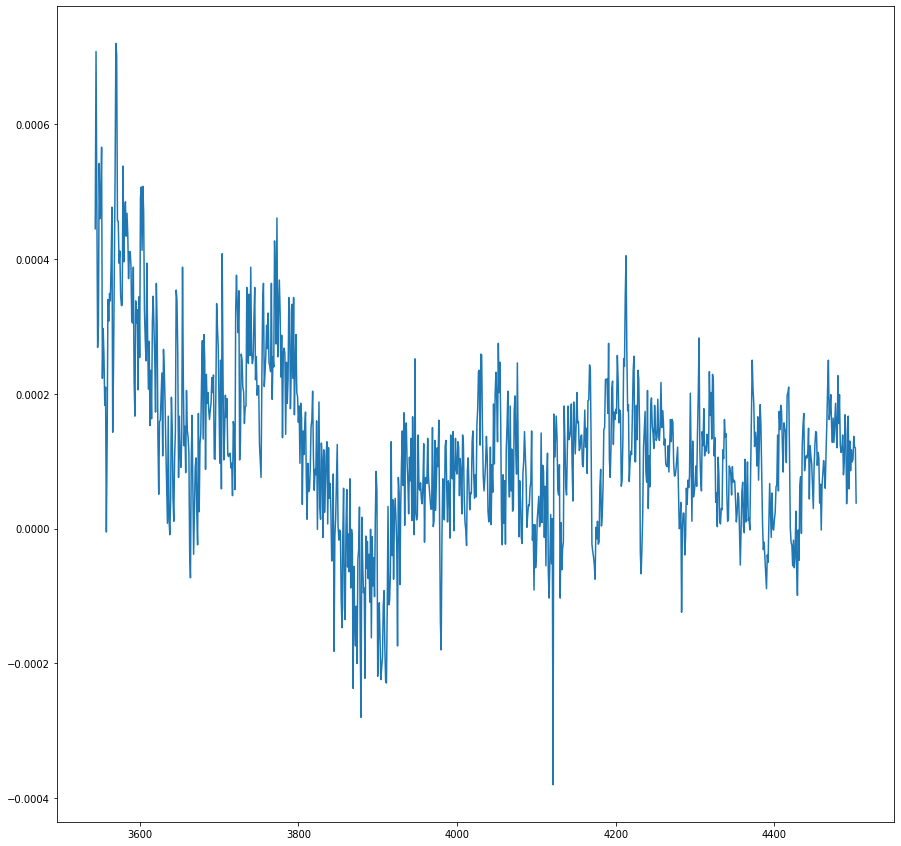

In [2]:
df = pd.read_csv('/home/harry/trading_algo/crypto_trading_researches/strategy_backtests/historical_data/historical_funding/HNT-PERP_historical_funding_data.csv')
plt.plot(df['rate'].tail(960))

### below is BNB's spread density curve from 2019-09-27 to 2021-03-26

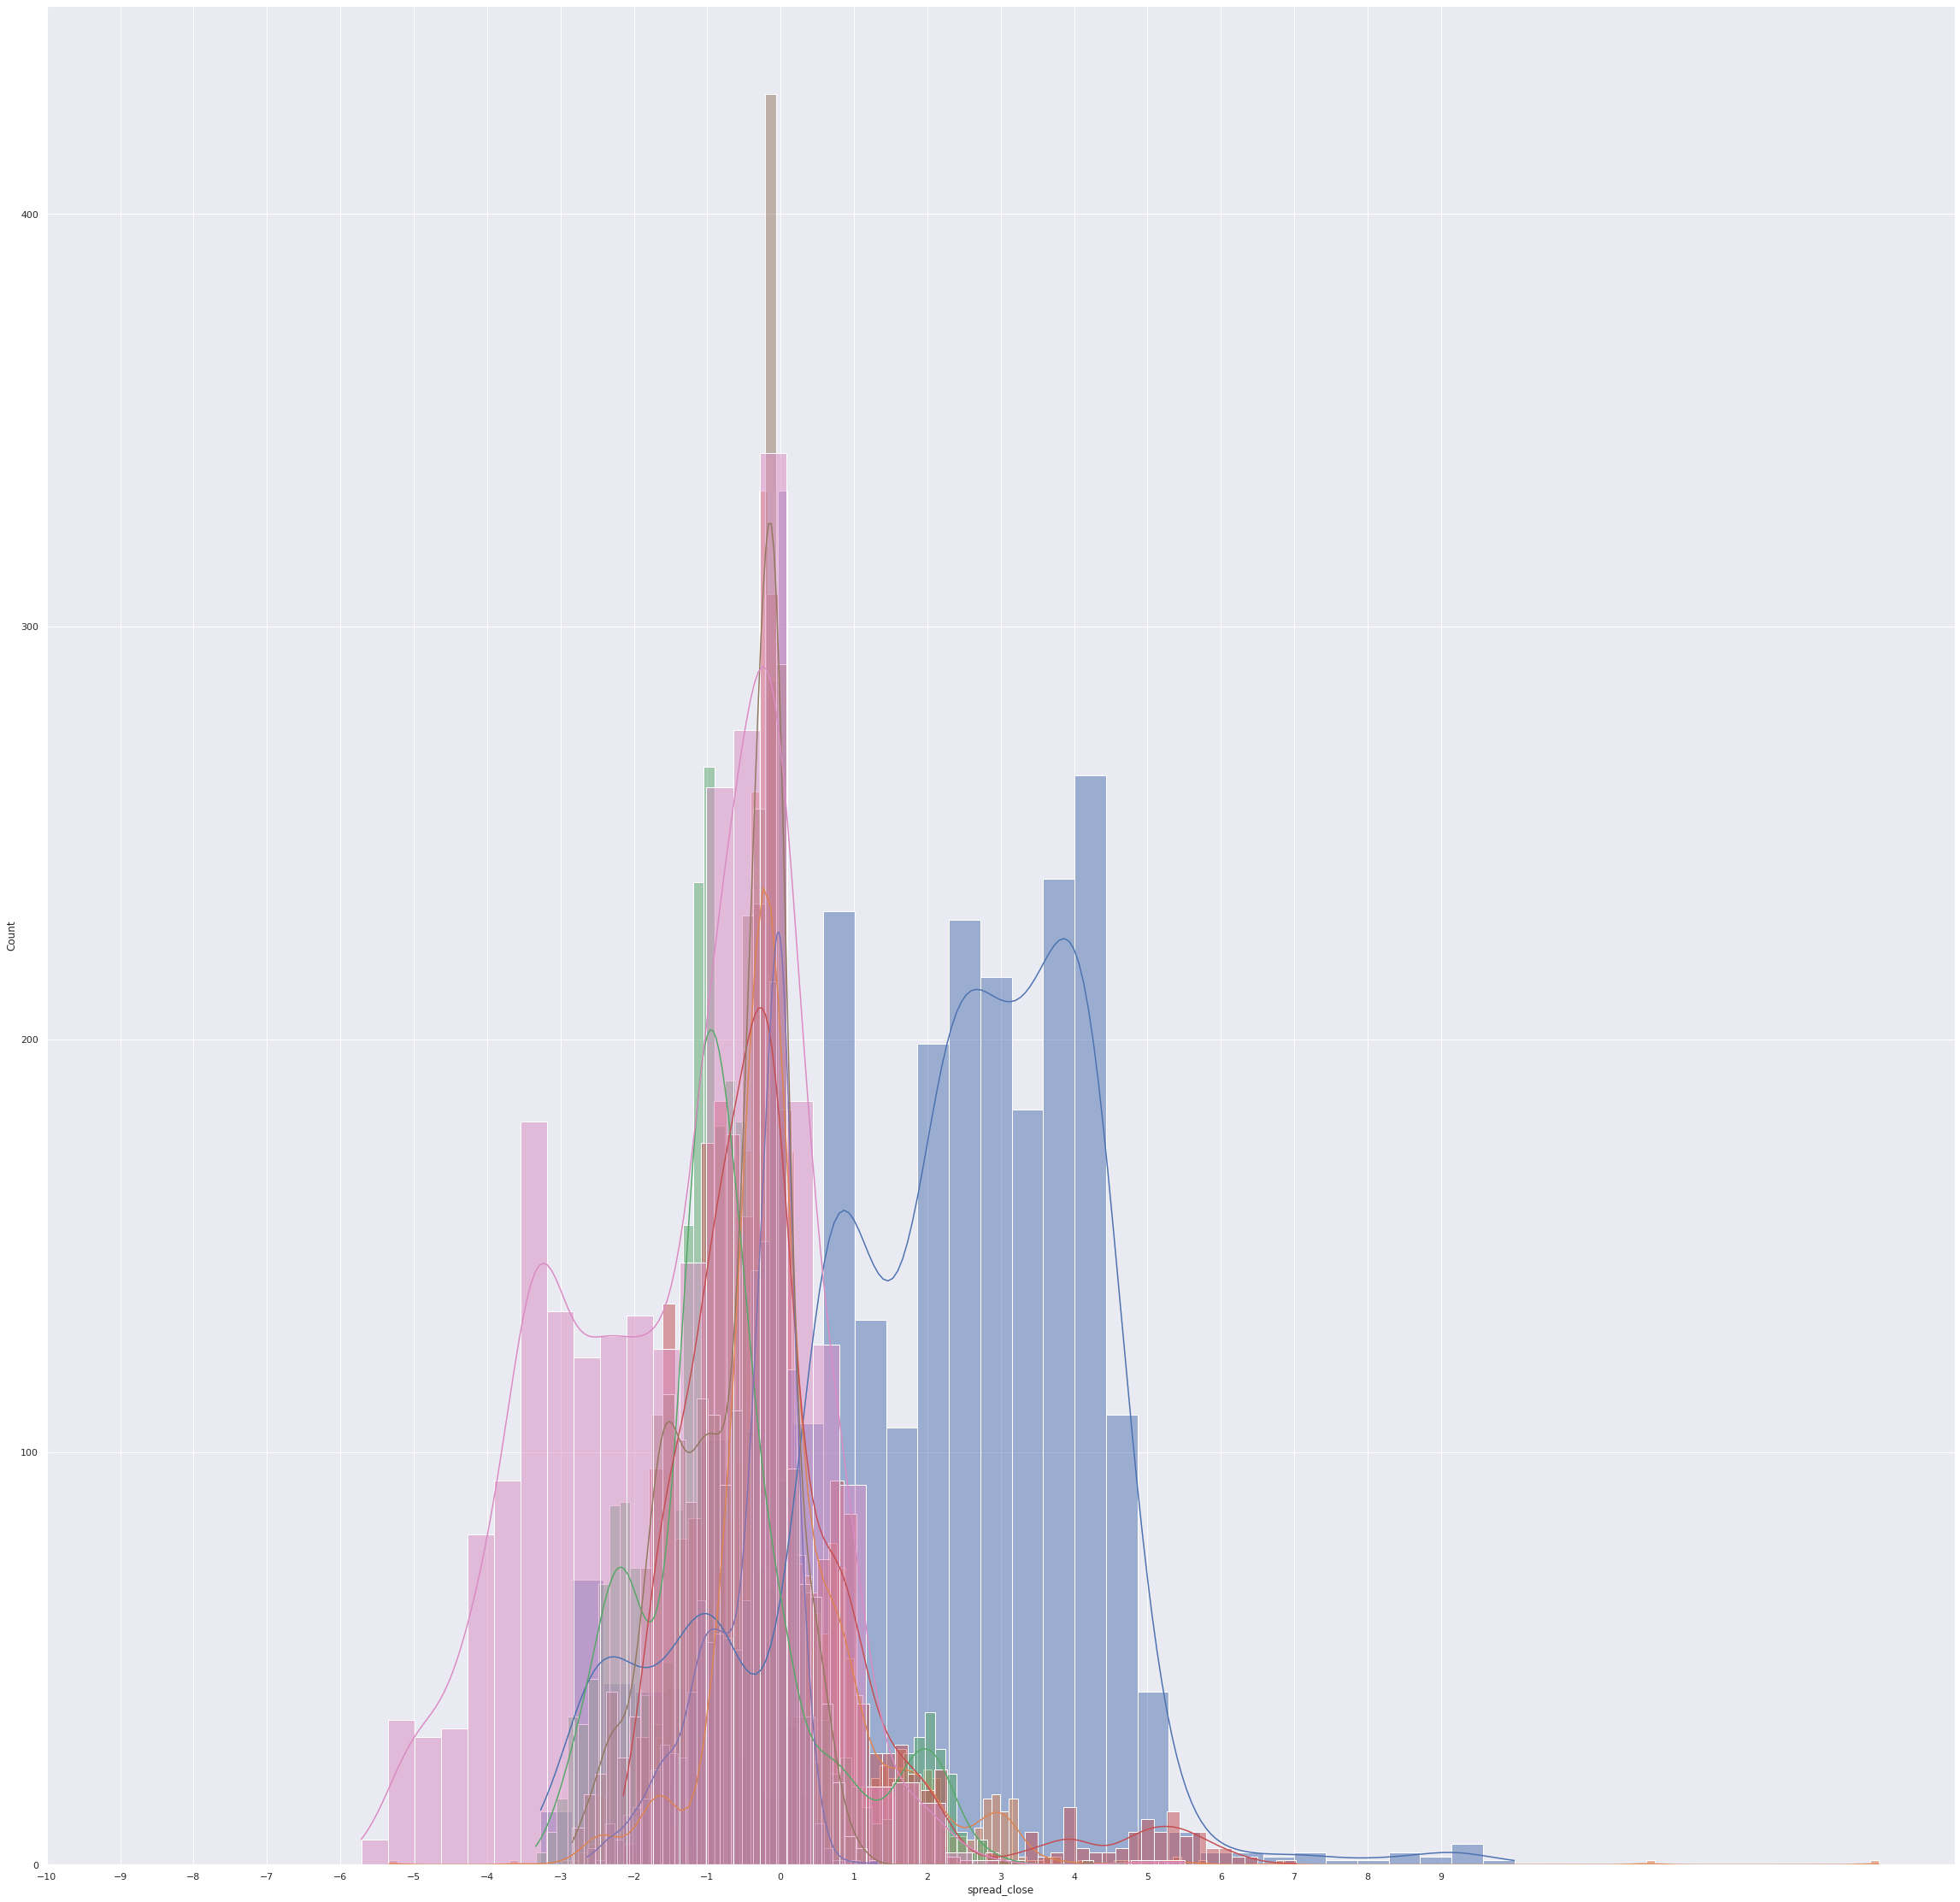

In [26]:
corr.plot_spread_price_distribution('TRX', timeframe='H', histogram=True)


### plot a single futures contract

<AxesSubplot:xlabel='spread_close', ylabel='Count'>

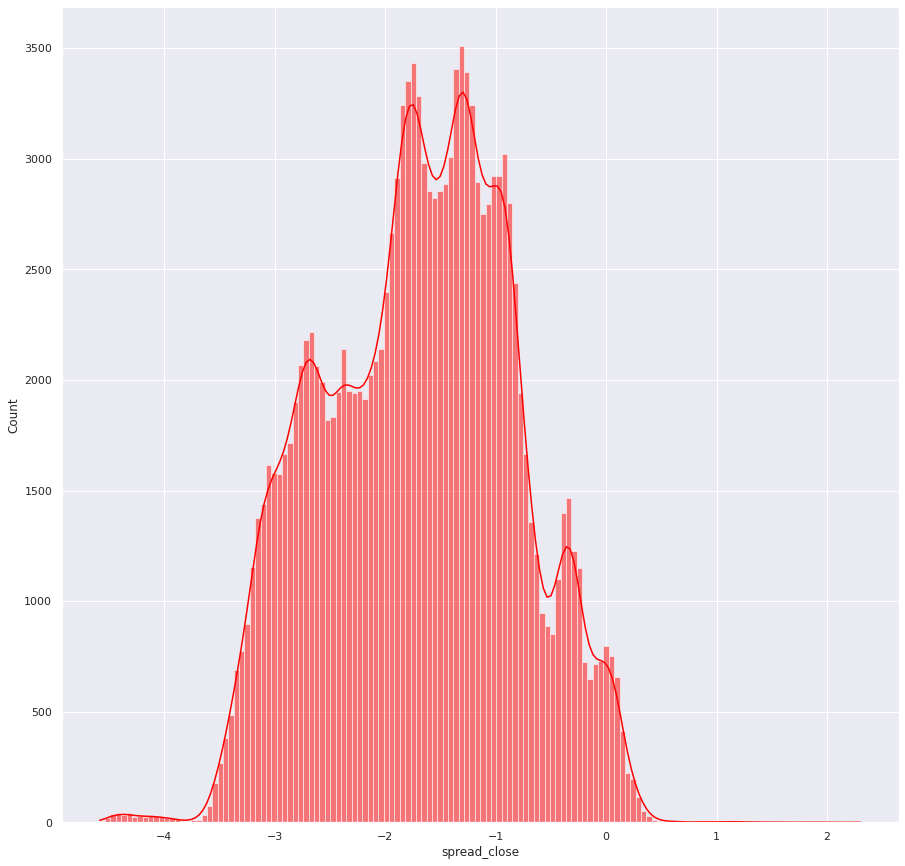

In [6]:
df = pd.read_csv('/home/harry/trading_algo/crypto_trading_researches/strategy_backtests/historical_data/all_spreads/LINK-0326_spread_data.csv')
sns.histplot(data=df['spread_close'], color='red', kde=True)

### plot perp-spot 

In [41]:
df_spot = CSVManager('/home/harry/trading_algo/crypto_trading_researches/strategy_backtests/historical_data/all_spots/BTC_historical_data.csv').change_resolution('15T', 'SPOT')
df_perp = CSVManager('/home/harry/trading_algo/crypto_trading_researches/strategy_backtests/historical_data/all_perps/BTC-PERP_historical_data.csv').change_resolution('15T', 'PERP')

df_perp.rename(columns={'open': 'perp_open', 'high': 'perp_high', 'low': 'perp_low', 'close': 'perp_close', 'volume': 'perp_volume'}, inplace=True)
df_spot.rename(columns={'open': 'spot_open', 'high': 'spot_high', 'low': 'spot_low', 'close': 'spot_close', 'volume': 'spot_volume'}, inplace=True)
                            
joint_df = pd.merge(df_perp, df_spot, how='inner', on=['timestamp'])

joint_df['spread_open'] = joint_df['perp_open'] - joint_df['spot_open']
joint_df['spread_open%'] = (joint_df['perp_open'] - joint_df['spot_open'])/joint_df['perp_open']*100

joint_df['spread_high'] = joint_df['perp_high'] - joint_df['spot_high']
joint_df['spread_high%'] = (joint_df['perp_high'] - joint_df['spot_high'])/joint_df['perp_high']*100

joint_df['spread_low%'] = joint_df['perp_low'] - joint_df['spot_low']
joint_df['spread_low'] =(joint_df['perp_low'] - joint_df['spot_low'])/joint_df['perp_low']*100

joint_df['spread_close'] = joint_df['perp_close'] - joint_df['spot_close']
joint_df['spread_close%'] = (joint_df['perp_close'] - joint_df['spot_close'])/joint_df['perp_close']*100

joint_df.drop(columns=['perp_open', 'spot_open', 'perp_high', 'spot_high', 'perp_low', 'spot_low', 'perp_close', 'spot_close'], inplace=True)
joint_df=joint_df.set_index('timestamp')
joint_df

perp_volume  funding_rate   spot_volume  \
timestamp                                                             
2019-07-21T13:15:00+00:00  5.210474e+04     -0.000013  0.000000e+00   
2019-07-21T13:30:00+00:00  5.068481e+04     -0.000013  0.000000e+00   
2019-07-21T13:45:00+00:00  4.453599e+04     -0.000013  0.000000e+00   
2019-07-21T14:00:00+00:00  4.787837e+04     -0.000003  0.000000e+00   
2019-07-21T14:15:00+00:00  1.015631e+05     -0.000003  0.000000e+00   
...                                 ...           ...           ...   
2021-04-02T22:30:00+00:00  5.530720e+06      0.000079  4.212970e+05   
2021-04-02T22:45:00+00:00  8.870727e+06      0.000079  6.142024e+05   
2021-04-02T23:00:00+00:00  6.870109e+06      0.000073  6.147905e+05   
2021-04-02T23:15:00+00:00  2.226618e+07      0.000073  2.038741e+06   
2021-04-02T23:30:00+00:00  1.159094e+07      0.000073  5.314347e+05   

                           spread_open  spread_open%  spread_high  \
timestamp                                                           
2019-07-21T13:15:00+00:00         0.25      0.002371        -0.25   
2019-07-21T13:30:00+00:00         3.00      0.028337        -0.75   
2019-07-21T13:45:00+00:00         3.25      0.030744         2.75   
2019-07-21T14:00:00+00:00         8.00      0.075883         2.00   
2019-07-21T14:15:00+00:00         0.75      0.007121        -0.50   
...                                ...           ...          ...   
2021-04-02T22:30:00+00:00       100.00      0.169621       118.00   
2021-04-02T22:45:00+00:00       117.00      0.198473       104.00   
2021-04-02T23:00:00+00:00       110.00      0.186643       106.00   
2021-04-02T23:15:00+00:00       109.00      0.185113       114.00   
2021-04-02T23:30:00+00:00       122.00      0.205897       126.00   

                           spread_high%  spread_low%  spread_low  \
timestamp                                                          
2019-07-21T13:15:00+00:00     -0.002361        -3.75   -0.035754   
2019-07-21T13:30:00+00:00     -0.007080         2.25    0.021353   
2019-07-21T13:45:00+00:00      0.026014         1.75    0.016612   
2019-07-21T14:00:00+00:00      0.018956        -4.75   -0.045157   
2019-07-21T14:15:00+00:00     -0.004740       -13.50   -0.130058   
...                                 ...          ...         ...   
2021-04-02T22:30:00+00:00      0.200081       113.00    0.191916   
2021-04-02T22:45:00+00:00      0.176140        97.00    0.164636   
2021-04-02T23:00:00+00:00      0.179609       109.00    0.185113   
2021-04-02T23:15:00+00:00      0.192356       113.00    0.191968   
2021-04-02T23:30:00+00:00      0.212339        35.00    0.059192   

                           spread_close  spread_close%  
timestamp                                               
2019-07-21T13:15:00+00:00          4.50       0.042499  
2019-07-21T13:30:00+00:00          3.25       0.030744  
2019-07-21T13:45:00+00:00          7.00       0.066398  
2019-07-21T14:00:00+00:00          0.75       0.007121  
2019-07-21T14:15:00+00:00         -3.00      -0.028722  
...                                 ...            ...  
2021-04-02T22:30:00+00:00        117.00       0.198473  
2021-04-02T22:45:00+00:00        110.00       0.186643  
2021-04-02T23:00:00+00:00        109.00       0.185113  
2021-04-02T23:15:00+00:00        122.00       0.205897  
2021-04-02T23:30:00+00:00         18.00       0.030434  

[60031 rows x 11 columns]

<AxesSubplot:xlabel='timestamp'>

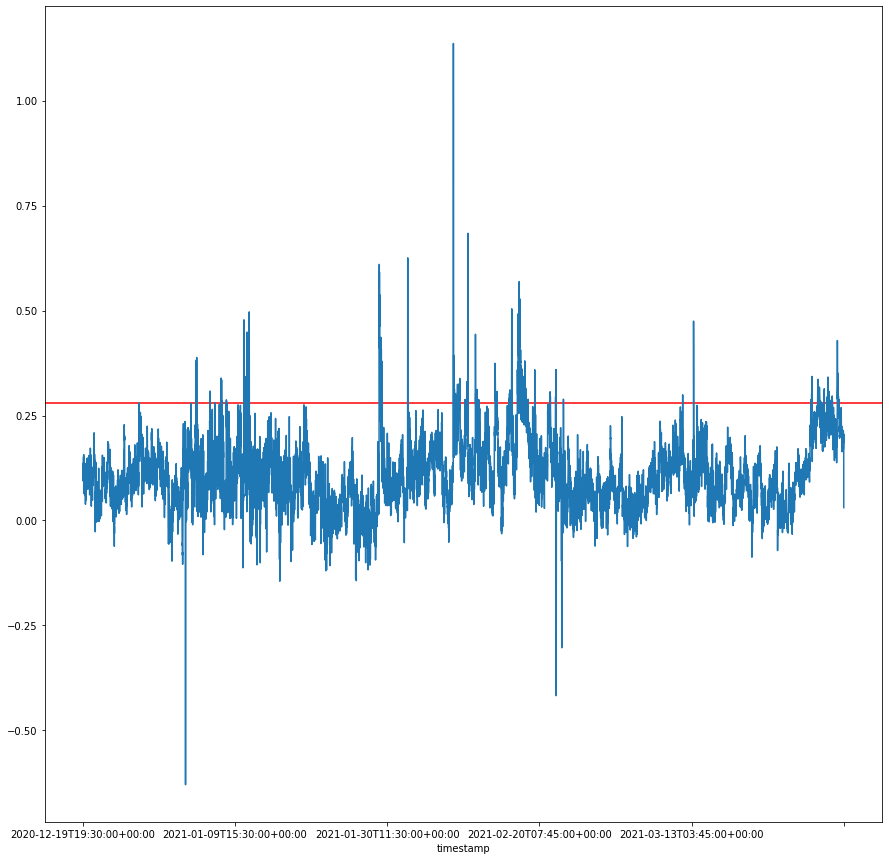

In [40]:

plt.axhline(y=0.28, color='r', linestyle='-')
joint_df['spread_close%'].tail(10000).plot()